In [130]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="1"
# import keras
# from keras import backend as K
# print(K.tensorflow_backend._get_available_gpus())
import pandas as pd
from surprise import SVD,Dataset,accuracy, KNNWithMeans,BaselineOnly
from surprise.model_selection import train_test_split
from surprise.reader import Reader
import random
import matplotlib.pyplot as plt

In [2]:
data = Dataset.load_from_file('./data/ratings.csv',Reader(skip_lines=20000000,sep=','))
train,test = train_test_split(data,test_size=0.1,shuffle=True)
algo = KNNWithMeans(sim_options={'user_based':False,'name':'msd'})
algo.fit(train)
preds = algo.test(test)
accuracy.mae(preds)

Computing the msd similarity matrix...
Done computing similarity matrix.
MAE:  0.6384


0.638376030105172

In [80]:
data = Dataset.load_from_file('./data/ratings.csv',Reader(skip_lines=1,sep=','))
train,test = train_test_split(data,test_size=0.1,shuffle=True)
algo = SVD(verbose=True)
algo.fit(train)
preds = algo.test(test)
accuracy.mae(preds)

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
MAE:  0.5952


0.5952239342908552

In [79]:
algo = BaselineOnly()
algo.fit(train)
preds = algo.test(test)
accuracy.mae(preds)

Estimating biases using als...
MAE:  0.6643


0.6643331265075538

In [121]:
views = []
negatives = set()
all_reviews = set()
for datum in data.raw_ratings:
    all_reviews.add((datum[0],datum[1]))
views = random.sample(all_reviews,100000)
while len(negatives) < 100000:
    print(len(negatives))
    first = random.sample(all_reviews,100)
    second = random.sample(all_reviews,100)
    for f in first:
        for s in second:
            first_p = (f[0],s[1])
            second_p = (s[0],f[1])
            if first_p not in all_reviews:
                negatives.add((first_p))
            if second_p not in all_reviews:
                negatives.add((second_p))

0
15545
30330
45413
60739
75889
90223


In [102]:
preds[0][3]

2.5874784893970704

In [122]:
uid = []
iid = []
pred_this = []
for view in views:
    pred_this.append((view[0],view[1],0))
for neg in negatives:
    pred_this.append((neg[0],neg[1],0))
preds = algo.test(pred_this)

In [132]:
v = set(views)
thresh = 0.0
x = []
y = []
for i in range(500):
    correct = 0
    thresh += 0.01
    for pred in preds:
        pair = (pred[0],pred[1])
        if pred[3] > thresh:
            if pair in v:
                correct += 1
        else:
            if pair in negatives:
                correct += 1
    x.append(thresh)
    y.append(correct/(len(v)+len(negatives)))

In [120]:
len(negatives)

1266136

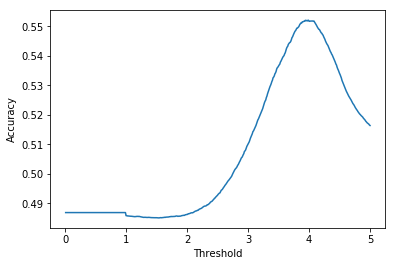

In [134]:
plt.plot(x,y)
plt.ylabel('Accuracy')
plt.xlabel('Threshold')
plt.show()